# ResNet-50 CNN: PyTorch & CIFAR-10

End-to-end programming tutorial including:

1. Progress bar - training model
1. Train model with _early stopping criterion_
1. Learning rate scheduler
1. Compare between learning rate scheduler and early stopping criterion


#### References 
- [Dive into Deep Learning - ResNet reference](https://d2l.ai/chapter_convolutional-modern/resnet.html)

- [YouTube reference](https://www.youtube.com/watch?v=DkNIBBBvcPs)

Refer to ResNet research paper: __Deep Residual Learning for Image Recognition__ by Kaiming He et al.

In page 4, Figure 3. ResNet-34 architecture is shown. It can learn more complex and new features in these 2 layers. But it's also going to use the skip connection/identity mapping from it previously leanred/coputed. So the CNN can kind of choose what it wants to learn. Either a combination of what it has learned before (skip connection) and the new things it has learned using the 2 conv layers within a ResNet block. The argument here is that the CNN is going to learn new things but it's at least never going to forget what it learned before. So, in theory, it should never become worse as we increase the depth of the CNN. Hence, by increasing the depth of the CNN, it never worsens the performance.

In page 5, Table 1, different architecture specific details are specified. In this tutorial, ResNet-50/101 and 152 will be implemented. The first conv layer: kernel size = (7, 7), stride = 2, number of kernels = 64, padding = 3; Max pool: kernel size = (3, 3), stride =2 

ResNet-50 has Four ResNet layers. If we look at the first ResNet layer, it has a block here which is-
- 1x1 filter with 64 channels
- 3x3, 64
- 1x1, 256

it repeats/performs this block 3 times.

Same convolutions - none of them change the size of input. Stride is used to reduce the spatial output in each of the conv layers.

One more thing to note is that if we look at the input channels for the first ResNet layer/block, it is 64 and the number of channels at the end is 256. For ResNet layer/block 2, the number of input channels is 128 and the number of channels at the end is 512. For ResNet layer/block 3, the number of input channels is 256 and the number of channels at the end is 1024. The ResNet architecture follows the pattern that the output channel is going to be 4x the input channel for that particular ResNet layer/block.

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms


from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"currently available device: {device}")

currently available device: cuda


In [4]:
# Get number of GPUs-
print(f"Number of available GPUs = {torch.cuda.device_count()}")

Number of available GPUs = 1


In [5]:
# Check the current GPU-
print(f"Current GPU = {torch.cuda.current_device()}")

Current GPU = 0


In [6]:
# Get the name of the current GPU
print(f"Name of current GPU = {torch.cuda.get_device_name(torch.cuda.current_device())}")

Name of current GPU = Quadro M6000


In [7]:
# Is PyTorch using a GPU?
print(f"PyTorch using a GPU? {torch.cuda.is_available()}")

PyTorch using a GPU? True


In [8]:
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 1.8.0


In [9]:
# Hyper-parameters-
num_epochs = 65
batch_size = 128
learning_rate = 0.01

In [10]:
print(f"number of epochs for training = {num_epochs} with default LR = {learning_rate}")

number of epochs for training = 65 with default LR = 0.01


In [11]:
# Define transformations for training and test sets-
transform_train = transforms.Compose(
    [
      transforms.RandomCrop(32, padding = 4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
     ]
     )

transform_test = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
     ]
     )

In [12]:
# Load dataset-
train_dataset = torchvision.datasets.CIFAR10(
        root = './data', train = True,
        download = True, transform = transform_train
        )

test_dataset = torchvision.datasets.CIFAR10(
        root = './data', train = False,
        download = True, transform = transform_test
        )

Files already downloaded and verified
Files already downloaded and verified


In [13]:
print(f"len(train_dataset) = {len(train_dataset)} & len(test_dataset) = {len(test_dataset)}")

len(train_dataset) = 50000 & len(test_dataset) = 10000


In [14]:
# Create training and testing loaders-
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size = batch_size,
        shuffle = False
        )

In [15]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 391 & len(test_loader) = 79


In [16]:
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

(390.625, 78.125)

In [17]:
# Sanity check-
images, labels = next(iter(train_loader))

images.size(), labels.shape

(torch.Size([128, 3, 32, 32]), torch.Size([128]))

In [18]:
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

# Sanity check-
images, labels = next(iter(train_loader))

images.size(), labels.shape

(torch.Size([128, 3, 32, 32]), torch.Size([128]))

### Define _ResNet-50_ architecture:

#### Basic _ResNet_ block

```identity_downsample``` is a conv layer which we might need to use depending on if we have changed the input size or if we have changed the number of channels. Hence, we need to adapt the identity so that we can use it later on when we have used a few conv layers. We use ```identity_downsample``` layer if we need to change the shape in some way.

In [19]:
class ResNet_block(nn.Module):
    def __init__(self, input_channels, output_channels, identity_downsample = None, stride = 1):
        super(ResNet_block, self).__init__()

        # number of channels after a block is 4x of what it entered/was passed-
        self.expansion = 4

        self.conv1 = nn.Conv2d(
            in_channels = input_channels, out_channels = output_channels,
            kernel_size = 1, stride = 1,
            padding = 0, bias = False)
        self.bn1 = nn.BatchNorm2d(num_features = output_channels)
        
        self.conv2 = nn.Conv2d(
            in_channels = output_channels, out_channels = output_channels,
            kernel_size = 3, stride = stride,
            padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(num_features = output_channels)
        
        self.conv3 = nn.Conv2d(
            in_channels = output_channels, out_channels = output_channels * self.expansion,
            kernel_size = 1, stride = 1,
            padding = 0, bias = False)
        self.bn3 = nn.BatchNorm2d(num_features = output_channels * self.expansion)
        
        self.relu = nn.ReLU()
        
        # A conv layer-
        self.identity_downsample = identity_downsample
        

    def forward(self, x):
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        
        x += identity
        x = self.relu(x)
        
        return x

    
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)

                '''
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                '''
            
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

        

### ResNet-50/101/152 architecture is _slightly_ changed for CIFAR-10 dataset instead of ImageNet dataset.

In [20]:
class ResNet(nn.Module):
    '''
    layers - a Python3 list specifying the number of times to use 'ResNet_block'
    '''
    
    def __init__(self, ResNet_block, layers, image_channels = 3, num_classes = 10):
        super(ResNet, self).__init__()
        
        self.input_channels = 64
        
        '''
        # For ImageNet-
        self.conv1 = nn.Conv2d(
            in_channels = image_channels, out_channels = 64,
            kernel_size = 7, stride = 2,
            padding = 3, bias = False)
        '''
        self.conv1 = nn.Conv2d(
            in_channels = image_channels, out_channels = 64,
            kernel_size = 3, stride = 1,
            padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(num_features = 64)
        self.relu = nn.ReLU()
        '''
        # For ImageNet-
        self.maxpool = nn.MaxPool2d(
            kernel_size = 3, stride = 2,
            padding = 1
            )
        '''
        
        # ResNet blocks-
        self.layer1 = self._make_layer(ResNet_block, layers[0], output_channels = 64, stride = 1)
        self.layer2 = self._make_layer(ResNet_block, layers[1], output_channels = 128, stride = 2)
        self.layer3 = self._make_layer(ResNet_block, layers[2], output_channels = 256, stride = 2)
        self.layer4 = self._make_layer(ResNet_block, layers[3], output_channels = 512, stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)  # For ImageNet
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        # Reshape before passing to dense layer-
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x


    def _make_layer(self, ResNet_block, num_residual_blocks, output_channels, stride):
        identity_downsample = None
        layers = []
        
        '''
        We want to know when are we going to actually use/do an identity_downsample? When are we going to
        have the conv layer change the identity?
        1. Either we change the input size
        2.
        '''
        if stride != 1 or self.input_channels != output_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels = self.input_channels, out_channels = 4 * output_channels,
                    kernel_size = 1, stride = stride,
                    bias = False),
                nn.BatchNorm2d(num_features = output_channels * 4)
                )
        
        # This is the layer that changes the number of channels-
        layers.append(ResNet_block(self.input_channels, output_channels, identity_downsample, stride))
        # After this first block, the number of channels is going to be changed
        
        self.input_channels = output_channels * 4       # 64 x 4 = 256
        # At the end of the first block, the output = 256
        
        for i in range(num_residual_blocks - 1):
            layers.append(ResNet_block(self.input_channels, output_channels))
        
        
        return (nn.Sequential(*layers))
        # *layers unpacks the list so that PyTorch knows that each comes after the other
        


In [21]:
def ResNet50(img_channels, num_channels = 1000):
    # Function to define ResNet-50 architecture
    return ResNet(ResNet_block, [3, 4, 6, 3], img_channels, num_channels)

In [41]:
def ResNet101(img_channels, num_channels = 1000):
    # Function to define ResNet-101 architecture
    return ResNet(ResNet_block, [3, 4, 23, 3], img_channels, num_channels)

In [43]:
def ResNet152(img_channels, num_channels = 1000):
    # Function to define ResNet-152 architecture
    return ResNet(ResNet_block, [3, 8, 36, 3], img_channels, num_channels)

In [22]:
def test(model):
    # Three images of (32, 32, 3). Number of in_channels = 3-
    x = torch.randn(3, 3, 32, 32)
    
    y = model(x).to(device)
    print(f"Output.shape: {y.shape}")
    
    return None


In [23]:
# Initialize a ResNet-50 model-
model = ResNet50(img_channels = 3, num_channels = 10)

In [24]:
# Sanity check-
model(images).shape

torch.Size([128, 10])

In [25]:
# Sanity check-
test(model)

Output.shape: torch.Size([3, 10])


In [26]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): ResNet_block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [27]:
# Place model on GPU-
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): ResNet_block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [28]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([64, 3, 3, 3]) has 1728 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 1, 1]) has 4096 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([256, 64, 1, 1]) has 16384 parameters
layer.shape = torch.Size([256]) has 256 parameters
layer.shape = torch.Size([256]) has 256 parameters
layer.shape = torch.Size([256, 64, 1, 1]) has 16384 parameters
layer.shape = torch.Size([256]) has 256 parameters
layer.shape = torch.Size([256]) has 256 parameters
layer.shape = torch.Size([64, 256, 1, 1]) has 16384 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64

In [29]:
print(f"Total number of parameters in ResNet-50 CNN for CIFAR-10 = {tot_params}")

Total number of parameters in ResNet-50 CNN for CIFAR-10 = 23520842


In [ ]:
'''
# Print layer names-
for layer in model.state_dict().keys():
    print(f"{layer} has dimension = {model.state_dict()[layer].shape}")
'''

In [30]:
# Save random initial weights-
torch.save(model.state_dict(), 'ResNet50_random_weights.pth')

In [21]:
# Load randomly initialised weights-
# model.load_state_dict(torch.load('ResNet50_random_weights.pth'))

<All keys matched successfully>

In [31]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 5e-4)

In [32]:
"""
def train_step(model, train_loader):
    running_loss = 0.0
    running_corrects = 0.0

    for batch, (images, labels) in enumerate(train_loader):
        # Attempt to push to GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # print(f"batch # = {batch}")

        model.train()

        # Forward pass-
        outputs = model(images)

        # Compute loss-
        J = loss(outputs, labels)

        # Backward pass-
        optimizer.zero_grad()   # empty accumulated gradients

        J.backward()    # perform backpropagation

        # Updates parameters-
        optimizer.step()
        
        # Compute model's performance statistics-
        running_loss += J.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        running_corrects += torch.sum(predicted == labels.data)

        '''
        # Print information every 100 steps-
        if (batch + 1) % 100 == 0:
            print(f"epoch {epoch + 1}/{num_epochs}, step {batch + 1}/{num_training_steps}, loss = {J.item():.4f}")
        '''

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = (running_corrects.double() / len(train_dataset)) * 100
    
    return epoch_loss, epoch_acc.cpu().numpy()
    
"""

In [32]:
def train_model_progress(model, train_loader):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()
    


In [34]:
"""
def validate_step(model, test_loader):
    total, correct = 0, 0
    running_loss_val = 0.0

    with torch.no_grad():
        for images, labels in test_loader:

            # Place features (images) and targets (labels) to GPU-
            images = images.to(device)
            labels = labels.to(device)

            # Set model to evaluation mode-
            model.eval()
    
            # Make predictions using trained model-
            outputs = model(images)
            _, y_pred = torch.max(outputs, 1)

            # Compute validation loss-
            J_val = loss(outputs, labels)

            running_loss_val += J_val.item() * labels.size(0)
    
            # Total number of labels-
            total += labels.size(0)

            # Total number of correct predictions-
            correct += (y_pred == labels).sum()

    epoch_val_loss = running_loss_val / len(test_dataset)
    val_acc = 100 * (correct / total)

    return epoch_val_loss, val_acc.cpu().numpy()

"""

In [33]:
def test_model_progress(model, test_loader):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [33]:
# Sanity check-
train_loss, train_acc = train_model_progress(model, train_loader)

Training: : 100%|██████████| 391/391 [04:08<00:00,  1.57batch/s, accuracy=45.5, loss=1.47]


In [34]:
# Sanity check-
val_loss, val_acc = test_model_progress(model, test_loader)

Validation: : 100%|██████████| 79/79 [00:08<00:00,  9.06batch/s, val_acc=56.6, val_loss=1.21]


### Train model _without_ learning rate scheduler, using early-stopping criterion

In [34]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 100
loc_patience = 0

In [35]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 3

In [36]:
training_history = {}

In [37]:
for epoch in range(num_epochs):

    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break

    train_loss, train_acc = train_model_progress(model, train_loader)
    val_loss, val_acc = test_model_progress(model, test_loader)
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    '''
    # Save best weights achieved until now-
    if (val_loss < best_val_loss):    
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "VGG18_best_model.pth")
    '''

    # Code for manual Early Stopping:
    # if np.abs(val_loss < best_val_loss) >= minimum_delta:
    if (val_loss < best_val_loss) and \
    (np.abs(val_loss - best_val_loss) >= minimum_delta):

        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss
        
        # reset 'loc_patience' variable-
        loc_patience = 0

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "ResNet50_best_model.pth")
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement
    

Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.18batch/s, val_acc=40, val_loss=1.68]   



epoch: 1 training loss = 1.8763, training accuracy = 32.97%, val_loss = 1.6837, val_accuracy = 40.00% & LR = 0.0100

Saving model with lowest val_loss = 1.6837



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.15batch/s, val_acc=58, val_loss=1.15]   



epoch: 2 training loss = 1.2924, training accuracy = 53.31%, val_loss = 1.1474, val_accuracy = 58.01% & LR = 0.0100

Saving model with lowest val_loss = 1.1474



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.03batch/s, val_acc=65.8, val_loss=0.985]



epoch: 3 training loss = 0.9865, training accuracy = 65.15%, val_loss = 0.9849, val_accuracy = 65.84% & LR = 0.0100

Saving model with lowest val_loss = 0.9849



Validation: : 100%|██████████| 79/79 [00:15<00:00,  4.99batch/s, val_acc=70.9, val_loss=0.881]



epoch: 4 training loss = 0.7820, training accuracy = 72.76%, val_loss = 0.8809, val_accuracy = 70.89% & LR = 0.0100

Saving model with lowest val_loss = 0.8809



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.00batch/s, val_acc=75.4, val_loss=0.749] 



epoch: 5 training loss = 0.6584, training accuracy = 77.28%, val_loss = 0.7486, val_accuracy = 75.44% & LR = 0.0100

Saving model with lowest val_loss = 0.7486



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.10batch/s, val_acc=77, val_loss=0.701]   



epoch: 6 training loss = 0.5698, training accuracy = 80.13%, val_loss = 0.7006, val_accuracy = 77.02% & LR = 0.0100

Saving model with lowest val_loss = 0.7006



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.22batch/s, val_acc=80.5, val_loss=0.59]  



epoch: 7 training loss = 0.5105, training accuracy = 82.36%, val_loss = 0.5904, val_accuracy = 80.48% & LR = 0.0100

Saving model with lowest val_loss = 0.5904



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.14batch/s, val_acc=83.4, val_loss=0.503] 



epoch: 8 training loss = 0.4598, training accuracy = 84.14%, val_loss = 0.5028, val_accuracy = 83.41% & LR = 0.0100

Saving model with lowest val_loss = 0.5028



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.11batch/s, val_acc=81.6, val_loss=0.576] 



epoch: 9 training loss = 0.4188, training accuracy = 85.56%, val_loss = 0.5765, val_accuracy = 81.64% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.13batch/s, val_acc=81.9, val_loss=0.559] 



epoch: 10 training loss = 0.3800, training accuracy = 86.67%, val_loss = 0.5593, val_accuracy = 81.91% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:14<00:00,  5.30batch/s, val_acc=83.5, val_loss=0.55]  


epoch: 11 training loss = 0.3567, training accuracy = 87.68%, val_loss = 0.5501, val_accuracy = 83.51% & LR = 0.0100


'EarlyStopping' called!



In [38]:
training_history.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

In [39]:
training_history[2].keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])

In [40]:
training_history[2]['val_acc']

array(58.01, dtype=float32)

In [41]:
import pickle

In [42]:
with open("ResNet50_earlystopping_training_history.pkl", "wb") as file:
    pickle.dump(training_history, file)

In [43]:
# Get model metrics at last epoch-
val_loss, val_acc = test_model_progress(model = model, test_loader = test_loader)

Validation: : 100%|██████████| 79/79 [00:15<00:00,  4.95batch/s, val_acc=83.5, val_loss=0.55]  


In [44]:
print(f"ResNet-50 (Early Stopping) val_acc = {val_acc:.2f}%")

ResNet-50 (Early Stopping) val_acc = 83.51%


In [45]:
# Save trained weights-
torch.save(model.state_dict(), 'ResNet50_earlystopping_trained_weights.pth')

### Train model with _learning rate scheduler_

- Training dataset = 50000, batch size = 128, number of training steps/iterations = 50000 / 128 = 391

- Initial learning rate warmup: 391 x 10 = 3910 steps or, 10 epochs at LR = 0.1

- Until 25th epoch or, 9775 steps use LR = 0.1

- From 26th epoch until 40th epoch or, 15640 steps use LR = 0.01

- From 41st epoch until 50th epoch or, 19550 steps use LR = 0.001

- From 51st epoch until 60th epoch use LR = 0.0001

In [46]:
boundaries = [9775, 15640, 19550]
values = [0.1, 0.01, 0.001, 0.0001]

In [48]:
# Initialize a ResNet-50 model-
model = ResNet50(img_channels = 3, num_channels = 10)

In [49]:
# Load random weights from before-
model.load_state_dict(torch.load('ResNet50_random_weights.pth'))

<All keys matched successfully>

In [50]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0, momentum = 0.9, weight_decay = 5e-4)

In [51]:
# Sanity check-
optimizer.param_groups[0]['lr']

0.0

In [52]:
def decay_function(step, boundaries = [9775, 15640, 19550], values = [0.1, 0.01, 0.001, 0.0001]):
    '''
    1 epoch has 391 steps/iterations using batch size used above.
    
    Until 25th epochs, or 25 x 391 = 9775 steps, use lr = 0.1
    From 26th epoch until 40th epoch, or 15640 steps use LR = 0.01
    From 41st epoch until 50th epoch or, 19550 steps use LR = 0.001
    From 51st epoch until 60th epoch use LR = 0.0001
    '''
    
    for idx, bound in enumerate(boundaries):
        if step < bound:
            return values[idx]

    return values[-1]


In [53]:
class schedule():

    def __init__(self, initial_learning_rate = 0.1, warmup_steps = 1000, decay_func = None):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_func = decay_func
        self.warmup_step_size = initial_learning_rate/warmup_steps
        self.current_lr = 0

    def get_lr(self, step):
        if step == 0:
            return self.current_lr
        elif step <= self.warmup_steps:
            self.current_lr+=self.warmup_step_size
            return self.current_lr
        elif step > self.warmup_steps:
            if self.decay_func:
                return self.decay_func(step)
        else:
            return self.current_lr


In [54]:
# 391 x 10 = 3910 steps (or, 10 epochs) is learning rate warmup
custom_lr_scheduler = schedule(
    initial_learning_rate = 0.1, warmup_steps = 3910,
    decay_func = decay_function
)

In [55]:
step = 0

In [56]:
def train_model_progress(model, train_loader):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            global step
            optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)

            step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()
    


In [57]:
def test_model_progress(model, test_loader):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [58]:
# Place model on GPU (if available)-
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): ResNet_block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [59]:
training_history_lr_scheduler = {}

In [60]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 100
loc_patience = 0

In [61]:
for epoch in range(num_epochs):

    train_loss, train_acc = train_model_progress(model, train_loader)
    val_loss, val_acc = test_model_progress(model, test_loader)
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history_lr_scheduler[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    
    # Save best weights achieved until now-
    if (val_loss < best_val_loss):    
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "ResNet50_lr_scheduler_best_model.pth")
    


Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.20batch/s, val_acc=43.2, val_loss=1.6]  



epoch: 1 training loss = 1.9413, training accuracy = 29.83%, val_loss = 1.6045, val_accuracy = 43.16% & LR = 0.0100

Saving model with lowest val_loss = 1.6045



Validation: : 100%|██████████| 79/79 [00:14<00:00,  5.29batch/s, val_acc=60.2, val_loss=1.16] 



epoch: 2 training loss = 1.3228, training accuracy = 52.82%, val_loss = 1.1645, val_accuracy = 60.22% & LR = 0.0200

Saving model with lowest val_loss = 1.1645



Validation: : 100%|██████████| 79/79 [00:14<00:00,  5.47batch/s, val_acc=63.7, val_loss=1.22] 



epoch: 3 training loss = 0.9932, training accuracy = 65.08%, val_loss = 1.2222, val_accuracy = 63.75% & LR = 0.0300



Validation: : 100%|██████████| 79/79 [00:16<00:00,  4.93batch/s, val_acc=75.3, val_loss=0.731] 



epoch: 4 training loss = 0.8103, training accuracy = 71.80%, val_loss = 0.7305, val_accuracy = 75.33% & LR = 0.0400

Saving model with lowest val_loss = 0.7305



Validation: : 100%|██████████| 79/79 [00:28<00:00,  2.77batch/s, val_acc=74.9, val_loss=0.761] 



epoch: 5 training loss = 0.6791, training accuracy = 76.59%, val_loss = 0.7615, val_accuracy = 74.88% & LR = 0.0500



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.20batch/s, val_acc=77.9, val_loss=0.672] 



epoch: 6 training loss = 0.6103, training accuracy = 79.05%, val_loss = 0.6725, val_accuracy = 77.92% & LR = 0.0600

Saving model with lowest val_loss = 0.6725



Validation: : 100%|██████████| 79/79 [00:16<00:00,  4.90batch/s, val_acc=73.1, val_loss=0.844]



epoch: 7 training loss = 0.5578, training accuracy = 80.65%, val_loss = 0.8439, val_accuracy = 73.13% & LR = 0.0700



Validation: : 100%|██████████| 79/79 [00:16<00:00,  4.84batch/s, val_acc=79.5, val_loss=0.595] 



epoch: 8 training loss = 0.5459, training accuracy = 81.30%, val_loss = 0.5951, val_accuracy = 79.48% & LR = 0.0800

Saving model with lowest val_loss = 0.5951



Validation: : 100%|██████████| 79/79 [00:15<00:00,  4.97batch/s, val_acc=77.2, val_loss=0.666] 



epoch: 9 training loss = 0.5255, training accuracy = 81.90%, val_loss = 0.6662, val_accuracy = 77.25% & LR = 0.0900



Validation: : 100%|██████████| 79/79 [00:15<00:00,  4.97batch/s, val_acc=77.8, val_loss=0.683] 



epoch: 10 training loss = 0.5145, training accuracy = 82.35%, val_loss = 0.6832, val_accuracy = 77.80% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:16<00:00,  4.74batch/s, val_acc=77.5, val_loss=0.665] 



epoch: 11 training loss = 0.5015, training accuracy = 82.80%, val_loss = 0.6655, val_accuracy = 77.48% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:16<00:00,  4.73batch/s, val_acc=79.2, val_loss=0.598] 



epoch: 12 training loss = 0.4799, training accuracy = 83.49%, val_loss = 0.5979, val_accuracy = 79.20% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:15<00:00,  4.99batch/s, val_acc=80.7, val_loss=0.554] 



epoch: 13 training loss = 0.4681, training accuracy = 83.91%, val_loss = 0.5535, val_accuracy = 80.74% & LR = 0.1000

Saving model with lowest val_loss = 0.5535



Validation: : 100%|██████████| 79/79 [00:14<00:00,  5.35batch/s, val_acc=78.8, val_loss=0.649] 



epoch: 14 training loss = 0.4488, training accuracy = 84.66%, val_loss = 0.6490, val_accuracy = 78.76% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.13batch/s, val_acc=76.1, val_loss=0.747] 



epoch: 15 training loss = 0.4504, training accuracy = 84.45%, val_loss = 0.7467, val_accuracy = 76.11% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:16<00:00,  4.84batch/s, val_acc=78.1, val_loss=0.643] 



epoch: 16 training loss = 0.4413, training accuracy = 84.95%, val_loss = 0.6433, val_accuracy = 78.11% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:14<00:00,  5.29batch/s, val_acc=79.5, val_loss=0.62]  



epoch: 17 training loss = 0.4380, training accuracy = 84.98%, val_loss = 0.6196, val_accuracy = 79.50% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.08batch/s, val_acc=80.8, val_loss=0.582] 



epoch: 18 training loss = 0.4282, training accuracy = 85.33%, val_loss = 0.5823, val_accuracy = 80.82% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:16<00:00,  4.90batch/s, val_acc=80.5, val_loss=0.594] 



epoch: 19 training loss = 0.4304, training accuracy = 85.19%, val_loss = 0.5942, val_accuracy = 80.50% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.02batch/s, val_acc=81, val_loss=0.567]   



epoch: 20 training loss = 0.4246, training accuracy = 85.48%, val_loss = 0.5668, val_accuracy = 81.01% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:16<00:00,  4.80batch/s, val_acc=82, val_loss=0.542]   



epoch: 21 training loss = 0.4215, training accuracy = 85.56%, val_loss = 0.5417, val_accuracy = 82.01% & LR = 0.1000

Saving model with lowest val_loss = 0.5417



Validation: : 100%|██████████| 79/79 [00:14<00:00,  5.60batch/s, val_acc=77, val_loss=0.777]   



epoch: 22 training loss = 0.4129, training accuracy = 85.81%, val_loss = 0.7774, val_accuracy = 77.04% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:16<00:00,  4.88batch/s, val_acc=81.9, val_loss=0.545] 



epoch: 23 training loss = 0.4183, training accuracy = 85.71%, val_loss = 0.5450, val_accuracy = 81.89% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:17<00:00,  4.61batch/s, val_acc=80.2, val_loss=0.637] 



epoch: 24 training loss = 0.4093, training accuracy = 85.97%, val_loss = 0.6368, val_accuracy = 80.15% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:14<00:00,  5.58batch/s, val_acc=83.9, val_loss=0.489] 



epoch: 25 training loss = 0.4068, training accuracy = 86.02%, val_loss = 0.4895, val_accuracy = 83.90% & LR = 0.1000

Saving model with lowest val_loss = 0.4895



Validation: : 100%|██████████| 79/79 [00:16<00:00,  4.91batch/s, val_acc=91.3, val_loss=0.245] 



epoch: 26 training loss = 0.2311, training accuracy = 92.21%, val_loss = 0.2449, val_accuracy = 91.30% & LR = 0.0100

Saving model with lowest val_loss = 0.2449



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.01batch/s, val_acc=91.9, val_loss=0.233] 



epoch: 27 training loss = 0.1757, training accuracy = 94.05%, val_loss = 0.2332, val_accuracy = 91.87% & LR = 0.0100

Saving model with lowest val_loss = 0.2332



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.17batch/s, val_acc=92.1, val_loss=0.226] 



epoch: 28 training loss = 0.1571, training accuracy = 94.73%, val_loss = 0.2262, val_accuracy = 92.07% & LR = 0.0100

Saving model with lowest val_loss = 0.2262



Validation: : 100%|██████████| 79/79 [00:14<00:00,  5.27batch/s, val_acc=92.2, val_loss=0.228] 



epoch: 29 training loss = 0.1418, training accuracy = 95.16%, val_loss = 0.2278, val_accuracy = 92.24% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:15<00:00,  4.97batch/s, val_acc=92, val_loss=0.235]   



epoch: 30 training loss = 0.1319, training accuracy = 95.40%, val_loss = 0.2351, val_accuracy = 91.95% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.01batch/s, val_acc=92.2, val_loss=0.233] 



epoch: 31 training loss = 0.1200, training accuracy = 95.91%, val_loss = 0.2331, val_accuracy = 92.22% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:14<00:00,  5.57batch/s, val_acc=92.2, val_loss=0.241] 



epoch: 32 training loss = 0.1079, training accuracy = 96.29%, val_loss = 0.2415, val_accuracy = 92.15% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.18batch/s, val_acc=92.4, val_loss=0.237] 



epoch: 33 training loss = 0.1039, training accuracy = 96.42%, val_loss = 0.2372, val_accuracy = 92.43% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.04batch/s, val_acc=91.8, val_loss=0.251] 



epoch: 34 training loss = 0.0978, training accuracy = 96.64%, val_loss = 0.2506, val_accuracy = 91.82% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.05batch/s, val_acc=91.8, val_loss=0.264] 



epoch: 35 training loss = 0.0932, training accuracy = 96.79%, val_loss = 0.2635, val_accuracy = 91.83% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:16<00:00,  4.81batch/s, val_acc=92.4, val_loss=0.245] 



epoch: 36 training loss = 0.0867, training accuracy = 97.01%, val_loss = 0.2450, val_accuracy = 92.41% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:16<00:00,  4.92batch/s, val_acc=92.5, val_loss=0.249] 



epoch: 37 training loss = 0.0855, training accuracy = 96.97%, val_loss = 0.2490, val_accuracy = 92.46% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:14<00:00,  5.36batch/s, val_acc=92.4, val_loss=0.262] 



epoch: 38 training loss = 0.0803, training accuracy = 97.20%, val_loss = 0.2616, val_accuracy = 92.40% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:17<00:00,  4.59batch/s, val_acc=92.3, val_loss=0.259] 



epoch: 39 training loss = 0.0809, training accuracy = 97.16%, val_loss = 0.2586, val_accuracy = 92.29% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:15<00:00,  4.94batch/s, val_acc=92.2, val_loss=0.259] 



epoch: 40 training loss = 0.0749, training accuracy = 97.46%, val_loss = 0.2594, val_accuracy = 92.21% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.10batch/s, val_acc=93.5, val_loss=0.218] 



epoch: 41 training loss = 0.0496, training accuracy = 98.36%, val_loss = 0.2185, val_accuracy = 93.50% & LR = 0.0010

Saving model with lowest val_loss = 0.2185



Validation: : 100%|██████████| 79/79 [00:17<00:00,  4.49batch/s, val_acc=93.7, val_loss=0.215] 



epoch: 42 training loss = 0.0368, training accuracy = 98.95%, val_loss = 0.2149, val_accuracy = 93.72% & LR = 0.0010

Saving model with lowest val_loss = 0.2149



Validation: : 100%|██████████| 79/79 [00:16<00:00,  4.65batch/s, val_acc=93.7, val_loss=0.214] 



epoch: 43 training loss = 0.0326, training accuracy = 99.06%, val_loss = 0.2140, val_accuracy = 93.67% & LR = 0.0010

Saving model with lowest val_loss = 0.2140



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.04batch/s, val_acc=93.8, val_loss=0.214] 



epoch: 44 training loss = 0.0294, training accuracy = 99.17%, val_loss = 0.2143, val_accuracy = 93.85% & LR = 0.0010



Validation: : 100%|██████████| 79/79 [00:17<00:00,  4.45batch/s, val_acc=93.6, val_loss=0.216] 



epoch: 45 training loss = 0.0264, training accuracy = 99.25%, val_loss = 0.2156, val_accuracy = 93.63% & LR = 0.0010



Validation: : 100%|██████████| 79/79 [00:16<00:00,  4.91batch/s, val_acc=93.8, val_loss=0.217] 



epoch: 46 training loss = 0.0253, training accuracy = 99.28%, val_loss = 0.2174, val_accuracy = 93.75% & LR = 0.0010



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.25batch/s, val_acc=93.8, val_loss=0.22]  



epoch: 47 training loss = 0.0239, training accuracy = 99.30%, val_loss = 0.2203, val_accuracy = 93.82% & LR = 0.0010



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.08batch/s, val_acc=93.8, val_loss=0.223] 



epoch: 48 training loss = 0.0225, training accuracy = 99.38%, val_loss = 0.2232, val_accuracy = 93.75% & LR = 0.0010



Validation: : 100%|██████████| 79/79 [00:16<00:00,  4.84batch/s, val_acc=93.8, val_loss=0.225] 



epoch: 49 training loss = 0.0216, training accuracy = 99.40%, val_loss = 0.2248, val_accuracy = 93.77% & LR = 0.0010



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.01batch/s, val_acc=93.8, val_loss=0.226] 



epoch: 50 training loss = 0.0191, training accuracy = 99.51%, val_loss = 0.2256, val_accuracy = 93.80% & LR = 0.0010



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.23batch/s, val_acc=94, val_loss=0.224]   



epoch: 51 training loss = 0.0193, training accuracy = 99.48%, val_loss = 0.2237, val_accuracy = 93.96% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.14batch/s, val_acc=93.8, val_loss=0.224] 



epoch: 52 training loss = 0.0180, training accuracy = 99.53%, val_loss = 0.2239, val_accuracy = 93.83% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.08batch/s, val_acc=93.9, val_loss=0.226] 



epoch: 53 training loss = 0.0182, training accuracy = 99.53%, val_loss = 0.2258, val_accuracy = 93.91% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:14<00:00,  5.29batch/s, val_acc=93.9, val_loss=0.225] 



epoch: 54 training loss = 0.0183, training accuracy = 99.50%, val_loss = 0.2251, val_accuracy = 93.89% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.06batch/s, val_acc=93.8, val_loss=0.226] 



epoch: 55 training loss = 0.0178, training accuracy = 99.55%, val_loss = 0.2259, val_accuracy = 93.81% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.20batch/s, val_acc=93.8, val_loss=0.226] 



epoch: 56 training loss = 0.0180, training accuracy = 99.51%, val_loss = 0.2258, val_accuracy = 93.82% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.07batch/s, val_acc=93.8, val_loss=0.225] 



epoch: 57 training loss = 0.0165, training accuracy = 99.58%, val_loss = 0.2254, val_accuracy = 93.84% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.21batch/s, val_acc=93.9, val_loss=0.225] 



epoch: 58 training loss = 0.0168, training accuracy = 99.60%, val_loss = 0.2250, val_accuracy = 93.87% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:13<00:00,  5.68batch/s, val_acc=93.9, val_loss=0.225] 



epoch: 59 training loss = 0.0168, training accuracy = 99.57%, val_loss = 0.2253, val_accuracy = 93.94% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:15<00:00,  4.98batch/s, val_acc=93.8, val_loss=0.226] 



epoch: 60 training loss = 0.0174, training accuracy = 99.57%, val_loss = 0.2257, val_accuracy = 93.81% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.08batch/s, val_acc=93.8, val_loss=0.224] 



epoch: 61 training loss = 0.0172, training accuracy = 99.53%, val_loss = 0.2241, val_accuracy = 93.84% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.21batch/s, val_acc=93.9, val_loss=0.226] 



epoch: 62 training loss = 0.0166, training accuracy = 99.56%, val_loss = 0.2256, val_accuracy = 93.89% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.01batch/s, val_acc=94, val_loss=0.224]   



epoch: 63 training loss = 0.0160, training accuracy = 99.60%, val_loss = 0.2241, val_accuracy = 93.95% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.16batch/s, val_acc=94, val_loss=0.223]   



epoch: 64 training loss = 0.0166, training accuracy = 99.61%, val_loss = 0.2235, val_accuracy = 93.98% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.20batch/s, val_acc=93.8, val_loss=0.225] 


epoch: 65 training loss = 0.0164, training accuracy = 99.57%, val_loss = 0.2255, val_accuracy = 93.85% & LR = 0.0001



In [62]:
# Save model from last training epoch-
torch.save(model.state_dict(), "ResNet50_lr_scheduler_last_epoch_model.pth")

In [65]:
# Initialize a new ResNet-50 model-
best_model = ResNet50(img_channels = 3, num_channels = 10)

In [66]:
# Load randomly initialised weights-
best_model.load_state_dict(torch.load('ResNet50_lr_scheduler_last_epoch_model.pth'))

<All keys matched successfully>

In [67]:
# Place model on GPU (if available)-
best_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): ResNet_block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [68]:
val_loss, val_acc = test_model_progress(best_model, test_loader)

Validation: : 100%|██████████| 79/79 [00:15<00:00,  5.02batch/s, val_acc=93.8, val_loss=0.225] 


In [70]:
print(f"ResNet-50 'best' (LR scheduler) model metrics: val_loss = {val_loss:.4f} & val_acc = {val_acc:.2f}%")

ResNet-50 'best' (LR scheduler) model metrics: val_loss = 0.2255 & val_acc = 93.85%


In [71]:
del best_model

In [72]:
del model

### Observation:

For this particular experiment, it seems that using ```val_loss``` as the metric to save the _best_ model is not the optimum choice.

_Highest validation accuracy_ achieved = 93.85%.

Also, there seems to be _overfitting_ happening. _Dropout_ needs to be employed.

In [73]:
# Sanity check-
training_history_lr_scheduler.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65])

In [74]:
training_history_lr_scheduler[12].keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])

In [2]:
import pickle

In [76]:
# Save training metrics as Python3 history for later analysis-
with open("ResNet50_training_history_lr_scheduler.pkl", "wb") as file:
    pickle.dump(training_history_lr_scheduler, file)

In [3]:
with open("ResNet50_training_history_lr_scheduler.pkl", "rb") as file:
    training_history_lr_scheduler = pickle.load(file)

In [4]:
training_history_lr_scheduler.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65])

In [5]:
training_history_lr_scheduler[12].keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])

In [6]:
training_history_lr_scheduler[12]['acc'], training_history_lr_scheduler[12]['val_acc']

(array(83.492), array(79.2, dtype=float32))

### Training Visualizations

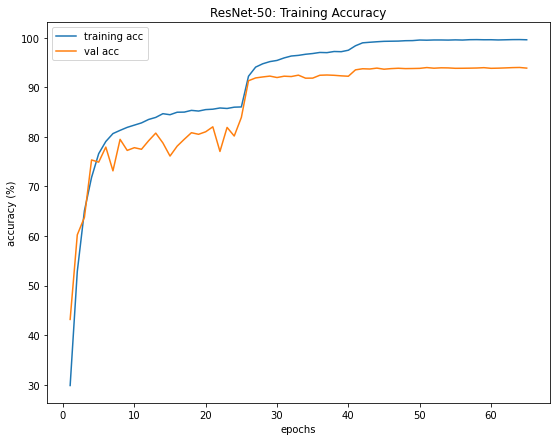

In [7]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['acc'] for k in training_history_lr_scheduler.keys()], label = 'training acc')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_acc'] for k in training_history_lr_scheduler.keys()], label = 'val acc')
plt.title("ResNet-50: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

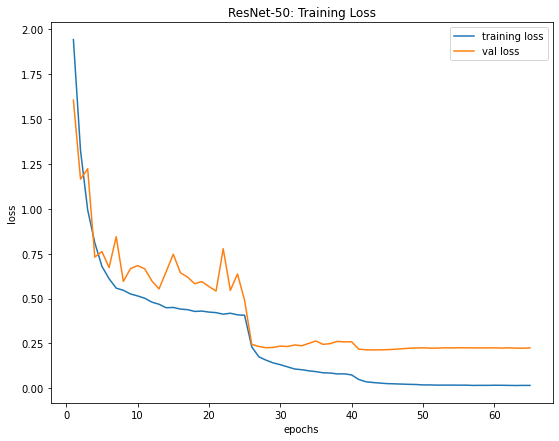

In [8]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['loss'] for k in training_history_lr_scheduler.keys()], label = 'training loss')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_loss'] for k in training_history_lr_scheduler.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("ResNet-50: Training Loss")
plt.show()

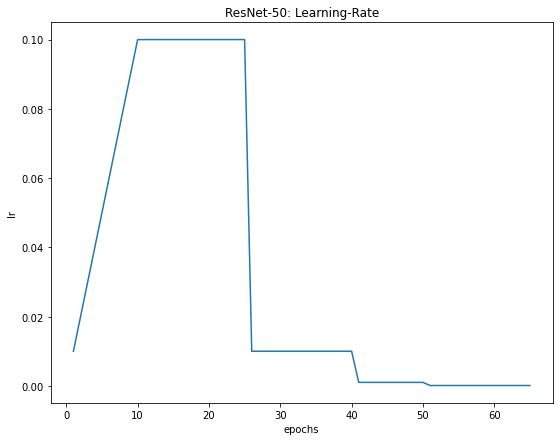

In [9]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['lr'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("ResNet-50: Learning-Rate")
plt.show()